### Second run, 1D CNN model Explanded Eval   
g1 dataset, preprocessed  
downsample to 125 hz, convert to millivolts  
diagnostic classes 0:Normal to 6  
Class 1 does not have any data, so skip for this test  
  * error corrected for missing class 1 in version 2.  
No bandpass filter as of this point. raw signals

copied from: ptbxl_1dcnn_v13.py  
June 26, 2025 11pm  
July 9 2:25 am  

In [1]:
import torch

#!/usr/bin/env python  
"""  
PTBXL 1D CNN Model v13
Adapted from MIT-BIH 1D CNN for PTBXL dataset

Input: ptbxl_cnn_ready_v13.csv (preprocessed ECG windows)  
Output: Trained 1D CNN model for PTBXL arrhythmia classification  

Classes: 0-6 based on PTBXL_class_labels.csv
- 0: Sinus Rhythm (Normal)
- 1: Left-axis Deviation  
- 2: T-wave abnormal
- 3: Atrial Fibrillation
- 4: 1st degree AV block
- 5: Left anterior fascicular block
- 6: Other arrhythmias (abnormal)

Author: Jennifer Yoon (adapted for PTBXL)  
Date: June 2025  
"""  

In [2]:
# Import supporting libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
from pathlib import Path

# Import main PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
def load_ptbxl_data(data_file):
    """
    Load PTBXL CNN-ready dataset

    Args:
        data_file: Path to ptbxl_cnn_ready_v13.csv

    Returns:
        X_data: Features (186 columns)
        y_data: Labels (class_label column)
    """

    print(f"Loading data from: {data_file}")

    # Load the preprocessed dataset
    data = pd.read_csv(data_file)
    print(f"Dataset shape: {data.shape}")

    # Split features and labels
    # Assuming columns 0-185 are features, column 186 is class_label
    if 'class_label' in data.columns:
        X_data = data.drop('class_label', axis=1).values
        y_data = data['class_label'].values
    else:
        # If no column names, assume last column is labels
        X_data = data.iloc[:, :-1].values  # All columns except last
        y_data = data.iloc[:, -1].values   # Last column

    print(f"Features shape: {X_data.shape}")
    print(f"Labels shape: {y_data.shape}")

    # Check for invalid labels
    unique_classes, counts = np.unique(y_data, return_counts=True)
    print(f"\nRaw class distribution:")
    for class_id, count in zip(unique_classes, counts):
        percentage = (count / len(y_data)) * 100
        print(f"  Class {class_id}: {count} samples ({percentage:.1f}%)")

    # Validate class labels
    min_class = int(np.min(y_data))
    max_class = int(np.max(y_data))
    print(f"\nLabel range: {min_class} to {max_class}")

    # Check for invalid values (NaN, negative, etc.)
    if np.any(np.isnan(y_data)):
        print("WARNING: Found NaN values in labels!")
        # Remove NaN samples
        valid_mask = ~np.isnan(y_data)
        X_data = X_data[valid_mask]
        y_data = y_data[valid_mask]
        print(f"Removed NaN samples. New shape: {X_data.shape}")

    # Ensure labels are integers
    y_data = y_data.astype(int)

    # Check if we need to remap labels to ensure continuous sequence from 0
    unique_labels = sorted(np.unique(y_data))
    expected_labels = list(range(len(unique_labels)))

    if unique_labels != expected_labels:
        print(f"WARNING: Labels are not continuous sequence. Remapping...")
        print(f"Found labels: {unique_labels}")
        print(f"Expected: {expected_labels}")

        label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
        print(f"Label mapping: {label_mapping}")

        # Apply mapping
        y_data_remapped = np.array([label_mapping[label] for label in y_data])
        y_data = y_data_remapped

        print(f"After remapping - Label range: {np.min(y_data)} to {np.max(y_data)}")

        # Update class names to match new mapping
        original_class_names = [
            'Sinus Rhythm (Normal)',           # Originally 0
            'Left-axis Deviation',             # Originally 1 (might be missing)
            'T-wave abnormal',                 # Originally 2
            'Atrial Fibrillation',             # Originally 3
            '1st degree AV block',             # Originally 4
            'Left anterior fascicular block',  # Originally 5
            'Other arrhythmias'                # Originally 6
        ]

        # Create new class names based on actual labels found
        remapped_class_names = []
        for old_label in unique_labels:
            if old_label < len(original_class_names):
                remapped_class_names.append(f"{original_class_names[old_label]} (was class {old_label})")
            else:
                remapped_class_names.append(f"Unknown class {old_label}")

        print(f"Remapped class names: {remapped_class_names}")

        # Store mapping info for later use
        setattr(load_ptbxl_data, 'label_mapping', label_mapping)
        setattr(load_ptbxl_data, 'remapped_class_names', remapped_class_names)
    else:
        print(f"✓ Labels are already in continuous sequence 0-{len(unique_labels)-1}")
        setattr(load_ptbxl_data, 'label_mapping', None)
        setattr(load_ptbxl_data, 'remapped_class_names', None)

    # Final class distribution
    unique_classes, counts = np.unique(y_data, return_counts=True)
    print(f"\nFinal class distribution:")
    for class_id, count in zip(unique_classes, counts):
        percentage = (count / len(y_data)) * 100
        print(f"  Class {int(class_id)}: {count} samples ({percentage:.1f}%)")

    # Validate that all labels are in expected range
    expected_max = len(unique_classes) - 1
    if np.max(y_data) > expected_max or np.min(y_data) < 0:
        raise ValueError(f"Invalid labels found! Expected range: 0-{expected_max}, "
                        f"Found range: {np.min(y_data)}-{np.max(y_data)}")

    print(f"✓ Label validation passed. Expected classes: 0-{expected_max}")

    return X_data, y_data

In [4]:
def create_train_test_split(X_data, y_data, test_size=0.2, random_state=42):
    """
    Split data into train and test sets with stratification

    Args:
        X_data: Feature data
        y_data: Label data
        test_size: Proportion for test set
        random_state: Random seed for reproducibility

    Returns:
        X_train, X_test, y_train, y_test
    """

    print(f"\nSplitting data: {1-test_size:.0%} train, {test_size:.0%} test")

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data,
        test_size=test_size,
        random_state=random_state,
        stratify=y_data  # Maintain class distribution in splits
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Check class distribution in splits
    print(f"\nTraining set class distribution:")
    unique_classes, counts = np.unique(y_train, return_counts=True)
    for class_id, count in zip(unique_classes, counts):
        percentage = (count / len(y_train)) * 100
        print(f"  Class {int(class_id)}: {count} samples ({percentage:.1f}%)")

    return X_train, X_test, y_train, y_test

In [5]:
def prepare_pytorch_data(X_train, X_test, y_train, y_test, batch_size=64):
    """
    Convert data to PyTorch tensors and create DataLoaders

    Args:
        X_train, X_test, y_train, y_test: Split datasets
        batch_size: Batch size for training

    Returns:
        train_loader, test_loader: PyTorch DataLoaders
    """

    print(f"\nPreparing PyTorch data with batch size: {batch_size}")

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    print(f"Training tensor shape: {X_train_tensor.shape}")
    print(f"Test tensor shape: {X_test_tensor.shape}")

    # Create DataLoader for training and testing data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Created DataLoaders: {len(train_loader)} training batches, {len(test_loader)} test batches")

    return train_loader, test_loader

In [6]:
# Define the 1D CNN model (adapted from original MIT-BIH model)
class PTBXL_ECGNet(nn.Module):
    def __init__(self, num_classes=7):  # 7 classes for PTBXL (0-6)
        super(PTBXL_ECGNet, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=80, stride=4, padding=38)
        self.bn1 = nn.BatchNorm1d(128)
        self.maxpool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Layer 2
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.maxpool2 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Layer 3
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.maxpool3 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Layer 4
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(512)
        self.maxpool4 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Output layer
        self.avgpool = nn.AdaptiveAvgPool1d(1)  # AdaptiveAvgPool1d to handle variable input lengths
        self.fc = nn.Linear(512, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Layer 1
        x = self.maxpool1(self.bn1(torch.relu(self.conv1(x))))
        # Layer 2
        x = self.maxpool2(self.bn2(torch.relu(self.conv2(x))))
        # Layer 3
        x = self.maxpool3(self.bn3(torch.relu(self.conv3(x))))
        # Layer 4
        x = self.maxpool4(self.bn4(torch.relu(self.conv4(x))))
        # Output layer
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.log_softmax(x)
        return x

In [7]:
def train_model(model, train_loader, test_loader, num_epochs=20, learning_rate=0.001,
                device='cpu', save_path='ptbxl_ecg_model_v13.pth'):
    """
    Train the 1D CNN model

    Args:
        model: PyTorch model
        train_loader, test_loader: Data loaders
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        device: 'cpu' or 'cuda'
        save_path: Path to save trained model

    Returns:
        model: Trained model
        train_losses, train_accuracies: Training metrics
        test_losses, test_accuracies: Test metrics
    """

    print(f"\nTraining model for {num_epochs} epochs on {device}")
    print(f"Learning rate: {learning_rate}")

    # Move model to device
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Track metrics
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    start_time = datetime.now()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        avg_train_loss = train_loss / len(train_loader)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        avg_test_loss = test_loss / len(test_loader)

        # Store metrics
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

    end_time = datetime.now()
    total_time = end_time - start_time
    print(f"\nTotal training time: {total_time}")

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to: {save_path}")

    return model, train_losses, train_accuracies, test_losses, test_accuracies


In [8]:
def train_model(model, train_loader, test_loader, num_epochs=20, learning_rate=0.001,
                device='cpu', save_path='ptbxl_ecg_model_v13.pth'):
    """
    Train the 1D CNN model

    Args:
        model: PyTorch model
        train_loader, test_loader: Data loaders
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        device: 'cpu' or 'cuda'
        save_path: Path to save trained model

    Returns:
        model: Trained model
        train_losses, train_accuracies: Training metrics
        test_losses, test_accuracies: Test metrics
    """

    print(f"\nTraining model for {num_epochs} epochs on {device}")
    print(f"Learning rate: {learning_rate}")

    # Move model to device
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Track metrics
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    start_time = datetime.now()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        avg_train_loss = train_loss / len(train_loader)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        avg_test_loss = test_loss / len(test_loader)

        # Store metrics
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

    end_time = datetime.now()
    total_time = end_time - start_time
    print(f"\nTotal training time: {total_time}")

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to: {save_path}")

    return model, train_losses, train_accuracies, test_losses, test_accuracies


In [9]:
def evaluate_model(model, test_loader, device='cpu', class_names=None):
    """
    Evaluate the trained model and generate detailed metrics including
    sensitivity (recall), specificity, and accuracy per class.

    Args:
        model: Trained PyTorch model
        test_loader: Test data loader
        device: 'cpu' or 'cuda'
        class_names: List of class names for reporting

    Returns:
        test_accuracy: Overall test accuracy
        y_true, y_pred: True and predicted labels
        class_metrics: Dictionary containing per-class metrics (accuracy, sensitivity, specificity)
    """

    print(f"\nEvaluating model on test set...")

    model.eval()
    y_true = []
    y_pred = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Overall Test Accuracy: {test_accuracy:.2f}%')

    # Generate classification report
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(np.unique(y_true)))]

    print(f"\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calculate confusion matrix for per-class metrics
    cm = confusion_matrix(y_true, y_pred)

    class_metrics = {}
    num_classes = len(class_names)

    print("\nPer-Class Metrics:")
    print("-" * 30)
    print(f"{'Class':<20} | {'Accuracy (%)':<12} | {'Sensitivity (%)':<15} | {'Specificity (%)':<15}")
    print("-" * 70)

    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - tp - fn - fp

        # Calculate accuracy, sensitivity, and specificity for each class
        class_accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Also known as recall
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        class_metrics[class_names[i]] = {
            'accuracy': class_accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity
        }

        print(f"{class_names[i]:<20} | {class_accuracy*100:<12.2f} | {sensitivity*100:<15.2f} | {specificity*100:<15.2f}")

    print("-" * 70)


    return test_accuracy, y_true, y_pred, class_metrics

In [10]:
def plot_training_history(train_losses, train_accuracies, test_losses, test_accuracies,
                         save_path='ptbxl_training_history_v13.png'):
    """
    Plot training history
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, test_losses, 'r-', label='Test Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Training history plot saved to: {save_path}")


In [11]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, save_path='ptbxl_confusion_matrix_v13.png'):
    """
    Plot confusion matrix
    """

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Confusion matrix saved to: {save_path}")

In [12]:
def main():
    """
    Main function to run PTBXL 1D CNN training
    """

    print("=" * 60)
    print("PTBXL 1D CNN Model Training v13")
    print("=" * 60)

    # Configuration
    data_file = "ptbxl_cnn_ready_v13.csv"
    batch_size = 64
    num_epochs = 20
    learning_rate = 0.001
    test_size = 0.2
    random_state = 42

    # Force CPU for debugging CUDA issues (comment out if you want to use GPU)
    # device = torch.device('cpu')
    # print(f"Forcing CPU mode for debugging")

    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Enable CUDA debugging if using GPU
    if device.type == 'cuda':
        print("Enabling CUDA error debugging...")
        os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

    # Class names for PTBXL (will be updated if remapping occurs)
    class_names = [
        'Sinus Rhythm (Normal)',      # 0
        'Left-axis Deviation',        # 1
        'T-wave abnormal',           # 2
        'Atrial Fibrillation',       # 3
        '1st degree AV block',       # 4
        'Left anterior fascicular block',  # 5
        'Other arrhythmias'          # 6
    ]

    try:
        # Step 1: Load data
        X_data, y_data = load_ptbxl_data(data_file)

        # Check if labels were remapped and update class names accordingly
        if hasattr(load_ptbxl_data, 'remapped_class_names') and load_ptbxl_data.remapped_class_names is not None:
            class_names = load_ptbxl_data.remapped_class_names
            print(f"Using remapped class names: {class_names}")
        else:
            # If no remapping, ensure class_names matches unique labels found
            unique_labels = sorted(np.unique(y_data))
            if len(class_names) != len(unique_labels):
                print(f"Warning: Number of initial class names ({len(class_names)}) does not match number of unique labels ({len(unique_labels)}).")
                # Adjust class names based on unique labels if not remapped
                class_names = [class_names[i] if i < len(class_names) else f'Unknown Class {i}' for i in unique_labels]
                print(f"Adjusted class names: {class_names}")


        # Step 2: Split data
        X_train, X_test, y_train, y_test = create_train_test_split(
            X_data, y_data, test_size=test_size, random_state=random_state
        )

        # Step 3: Prepare PyTorch data
        train_loader, test_loader = prepare_pytorch_data(
            X_train, X_test, y_train, y_test, batch_size=batch_size
        )

        # Step 4: Initialize model
        num_classes = len(np.unique(y_data))
        print(f"\nInitializing model with {num_classes} classes")
        model = PTBXL_ECGNet(num_classes=num_classes)

        print(f"\nModel architecture:")
        print(model)

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"\nTotal parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

        # Step 5: Train model
        model, train_losses, train_accuracies, test_losses, test_accuracies = train_model(
            model, train_loader, test_loader,
            num_epochs=num_epochs, learning_rate=learning_rate, device=device
        )

        # Step 6: Evaluate model
        test_accuracy, y_true, y_pred, class_metrics = evaluate_model(
            model, test_loader, device=device, class_names=class_names
        )

        # Step 7: Plot results
        plot_training_history(train_losses, train_accuracies, test_losses, test_accuracies)
        plot_confusion_matrix(y_true, y_pred, class_names=class_names)

        print(f"\n" + "=" * 60)
        print(f"Training completed successfully!")
        print(f"Final test accuracy: {test_accuracy:.2f}%")
        # Print per-class metrics again for clarity after the plots
        print("\nSummary of Per-Class Metrics:")
        print("-" * 30)
        print(f"{'Class':<20} | {'Accuracy (%)':<12} | {'Sensitivity (%)':<15} | {'Specificity (%)':<15}")
        print("-" * 70)
        for class_name, metrics in class_metrics.items():
             print(f"{class_name:<20} | {metrics['accuracy']*100:<12.2f} | {metrics['sensitivity']*100:<15.2f} | {metrics['specificity']*100:<15.2f}")
        print("-" * 70)

        print(f"Model saved as: ptbxl_ecg_model_v13.pth")
        print(f"=" * 60)

    except FileNotFoundError as e:
        print(f"Error: Could not find required file: {e}")
        print(f"Make sure {data_file} exists in the current directory")
    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()

PTBXL 1D CNN Model Training v13
Using device: cuda
Enabling CUDA error debugging...
Loading data from: ptbxl_cnn_ready_v13.csv
Dataset shape: (142962, 187)
Features shape: (142962, 186)
Labels shape: (142962,)

Raw class distribution:
  Class 0.0: 99322 samples (69.5%)
  Class 2.0: 15774 samples (11.0%)
  Class 3.0: 6402 samples (4.5%)
  Class 4.0: 3763 samples (2.6%)
  Class 5.0: 9714 samples (6.8%)
  Class 6.0: 7987 samples (5.6%)

Label range: 0 to 6
Found labels: [np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Expected: [0, 1, 2, 3, 4, 5]
Label mapping: {np.int64(0): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4, np.int64(6): 5}
After remapping - Label range: 0 to 5
Remapped class names: ['Sinus Rhythm (Normal) (was class 0)', 'T-wave abnormal (was class 2)', 'Atrial Fibrillation (was class 3)', '1st degree AV block (was class 4)', 'Left anterior fascicular block (was class 5)', 'Other arrhythmias (was class 6)']

Final class distr

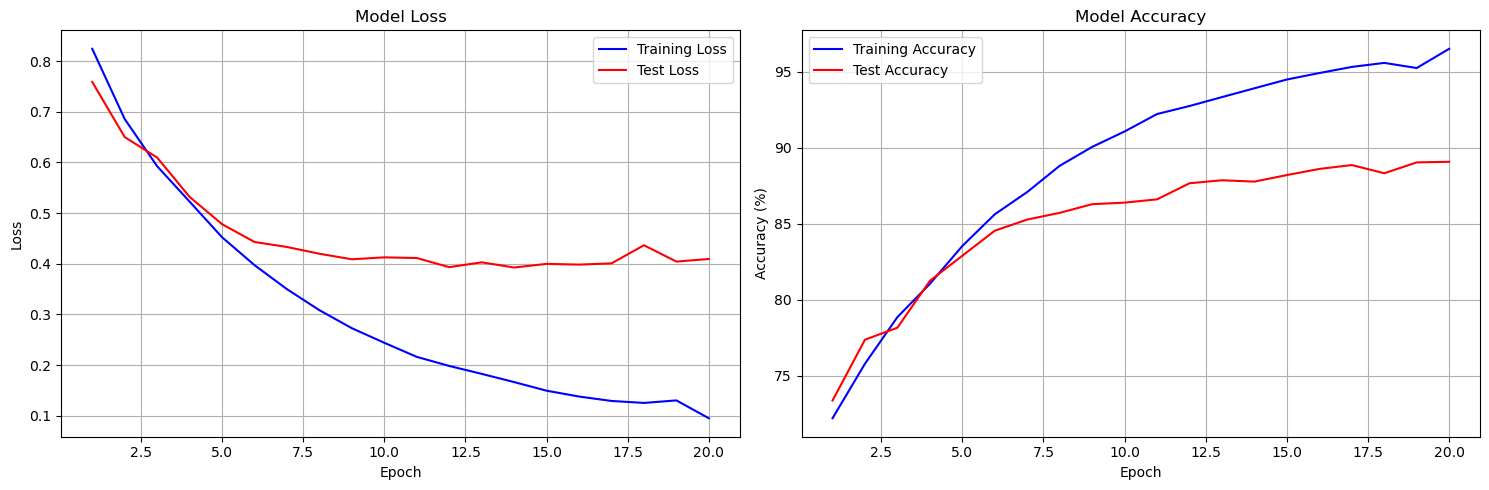

Training history plot saved to: ptbxl_training_history_v13.png


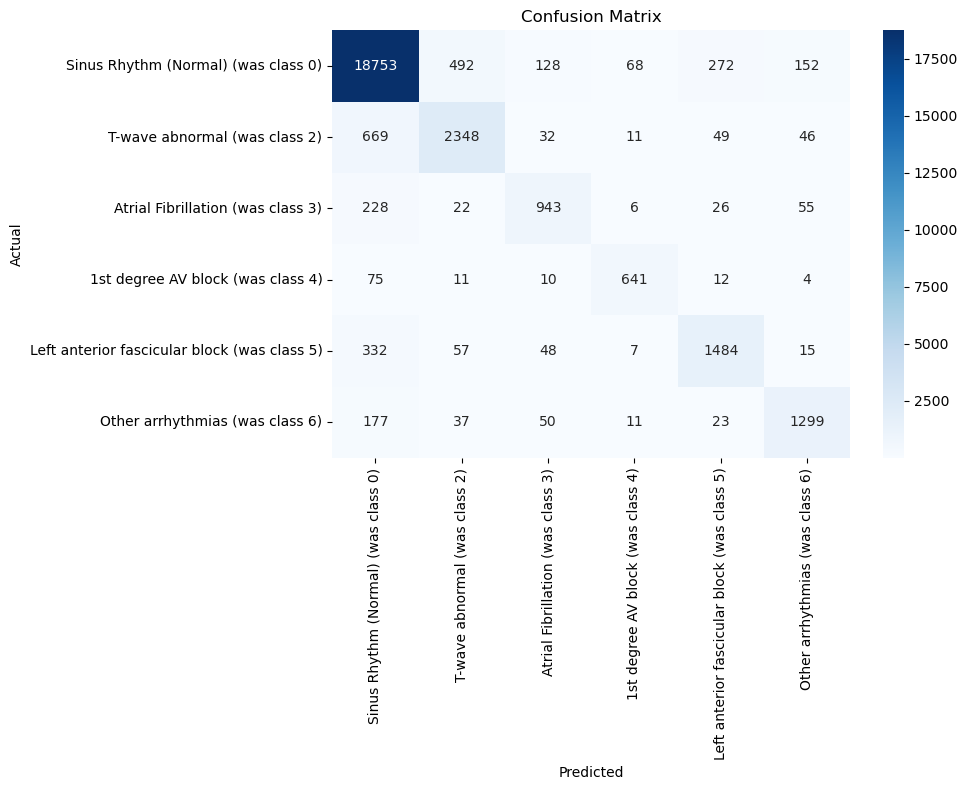

Confusion matrix saved to: ptbxl_confusion_matrix_v13.png

Training completed successfully!
Final test accuracy: 89.07%

Summary of Per-Class Metrics:
------------------------------
Class                | Accuracy (%) | Sensitivity (%) | Specificity (%)
----------------------------------------------------------------------
Sinus Rhythm (Normal) (was class 0) | 90.93        | 94.40           | 83.03          
T-wave abnormal (was class 2) | 95.01        | 74.42           | 97.57          
Atrial Fibrillation (was class 3) | 97.88        | 73.67           | 99.02          
1st degree AV block (was class 4) | 99.25        | 85.13           | 99.63          
Left anterior fascicular block (was class 5) | 97.06        | 76.38           | 98.57          
Other arrhythmias (was class 6) | 98.01        | 81.34           | 98.99          
----------------------------------------------------------------------
Model saved as: ptbxl_ecg_model_v13.pth


In [13]:
if __name__ == "__main__":
    main()